# Natural Language Processing - Part Two

Welcome to the Data Science Discovery Program's Natural Language Processing - Part Two workshop. If you haven't participated in part one of this two part workshop series on natural language processing, you can find the notebook in our GitHub repo: https://github.com/dlab-berkeley. <br>

This workshop covers word embeddings and topic modeling. Other methods like sentiment analysis are included in the notebook but will not be covered in the workshop. Here's the outline: <br>
* Word Emeddings <br>
    * gensim <br>
    * Pre-trained Word Embeddings <br>
    * Word Similarity <br>
    * Distance <br>
    * Analogies <br>
    * Training custom word embeddings <br>
* Sentiment Analysis (not covered in workshop) <br>
* Topic Modeling <br>
    * Latent Dirichlet Allocation <br>
    * Dimensionality Reduction (not covered in workshop)

## Word Embeddings: `word2vec`

What are word embedding? It is a way to transform words into a numerical format, specifically vectors, so they can be used as inputs to a model. In the Natureal Language Processing - Part One workshop, you may have seen a way to encode text as numbers using a bag-of-words approach, which takes into account the *frequency* of words to encode the text. <br>

However, what if we want to use the *meaning* of the word in our model instead? As humans, when we interpret text, we aren't just looking at how often a word appears, but also the context of the words (e.g., which words appear before or after, what words have a similar meaning, etc). <br>

Introducing . . . **word embeddings**! We embed a word (or a bi-gram, tri-gram, phrase, etc) as a vector in a higher dimensional space. The word embedding model, `word2vec`, is a way to find the vector representations of words (also referred to as tokens). The figure below illustrates these two approaches. <br>

The continuous bag-of-words (CBOW) approach predicts a single word using the words that come before and after it. The number of words before and after the target word that is looked at is the called the *window size*. For example, if we had the text `I went to the store to get some apples`, we may try to use the word vectors for `I`, `went`, `to`, `the`, `to`, `get`, `some`, `apples` to predict the word `store`. This would correspond to a *window size* of 4 because there are 4 words on either side of the target word. <br>

In the skip-gram model, we input a word and predict what words are related or predict what words we expect would come before and after it. In the above example, we'd aim to predict the remaining words in the sentence from the word vector for `store`. 

![word_embedding](../data/word_embedding.png)

These models are *neural networks*; specifically, a type of machine learning method called deep learning. The general idea is that there are nodes/neurons that are interconnected with different weights that are learned during the training process. The structure mimics the structure of the human brain, which is why they are called neural networks. Don't worry too much about the details for our purposes today. 

# gensim

`gensim` is a popular Python package for natural language processing. It is one of the fastest libraries for training vector embeddings, can handle large corpus, and has many other NLP uses, such as topic modeling (which we will get into later today!)

In [47]:
# Uncomment the line below and un if you do not already have gensim installed
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import gensim
import gensim.downloader as api

import pandas as pd
import numpy as np
import re

/Users/tiffanytra/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Pre-trained Word Embeddings

There are many word embedding models that have already been trained on a large corpus. There are many different models trained in different contexts already available on `gensim`. Here are some examples:

In [48]:
gensim_models = list(api.info()['models'].keys())
print(gensim_models)

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


We are going to take a closer look at the `word2vec-google-news-300` model: this is a word embedding model that is trained on Google News, where the embedding is 300 dimensions. Downloading this might take a while! The word embedding model is nearly 2 GB. 

In [4]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


There are a variety of methods we can use to explore the embeddings in this model. For example, `.index_to_key` will give us a list of the words/phrases (called the vocabulary) that we have vector embeddings for in this model. 

In [49]:
# 5 example words in the corpus
wv.index_to_key[:5]

['</s>', 'in', 'for', 'that', 'is']

We can find how many word vectors we have in this model by taking the length of this list.

In [50]:
n_words = len(wv.index_to_key)
print(f"Number of words: {n_words}")
print(wv.index_to_key[:20])

Number of words: 3000000
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are']


The model is trained using a vocabulary of size 3 million! This is a huge model, which takes hours to train. This is why we used a pre-trained model - we likely don't have the resources to train this on our local machines.

Accessing the actual word vectors can be done by treating the word vector model as a dictionary. For example, let's take a look at the word vector for `"banana"`:

In [51]:
print(wv["banana"])
print(wv["banana"].size)

[-8.54492188e-02  4.71191406e-02 -6.93359375e-02  3.02734375e-01
 -1.87500000e-01 -3.19824219e-02  2.95410156e-02 -2.05078125e-01
 -9.03320312e-02  2.98828125e-01  2.10937500e-01 -6.88476562e-02
  4.76074219e-02  5.83496094e-02 -2.75390625e-01  2.42187500e-01
 -3.22265625e-01  4.73632812e-02 -1.44531250e-01  9.37500000e-02
  6.74438477e-03  2.17773438e-01  2.31445312e-01  1.87500000e-01
  8.49609375e-02 -5.39550781e-02 -2.65625000e-01  2.23388672e-02
  2.24609375e-01  4.12109375e-01 -2.30712891e-02 -1.67968750e-01
  1.01928711e-02  2.10937500e-01  1.14135742e-02  2.50000000e-01
  8.64257812e-02 -2.16796875e-01  8.93554688e-02  1.50390625e-01
 -2.03125000e-01 -2.30468750e-01  1.42578125e-01  1.34765625e-01
 -1.13769531e-01 -1.80664062e-01  3.58886719e-02 -1.69921875e-01
  1.55273438e-01  2.39257812e-01 -2.30468750e-01 -9.96093750e-02
  1.82617188e-01 -1.81640625e-01 -1.46484375e-01 -7.03125000e-02
  9.37500000e-02 -2.67578125e-01  2.17285156e-02 -1.45507812e-01
 -2.38037109e-02  1.53320

The word vector has a dimension of 300. To us, these numbers are pretty uncomprehensible and uninterpretable, but we can now use these vectors to perform "calculations" on words to find words that are similar and dissimilar. A particular interesting use of word embeddings is to find words similar by *analogy*. 
<br> <br>
What do we expect below, based on the context we are given? <br> 
#### **geese - goose + toad = ?**

![word_analogy](../data/word_analogy.png)

 If you said toads, that's correct!

Note if you try to use a word not in the vocabulary (a word that is not present in the corpus the model was trained on), it will result in an error. This is a limitation of `Word2Vec`. It cannot infer vector embeddings for words that it has never seen before.

In [52]:
# this will error
wv["nbvouphr"]

KeyError: "Key 'nbvouphr' not present"

# Word Similarity

A semantic question we can ask is what words are similar to "banana". How does word similarity look in vector operations? We'd expect similar words to have vectors that are closer to each other in vector space.

There are many metrics of vector similarity - one of the most useful ones is the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). It has a range of 0 to 1, with orthogonal vectors have a cosine similarity of 0, and parallel vectors having a cosine similarity of 1. `gensim` provides a function that lets us find the most similar vectors to a queried vector - let's give it a shot! 

In [53]:
wv.most_similar('watermelon')

[('melon', 0.6983706951141357),
 ('watermelons', 0.6827898621559143),
 ('pumpkin', 0.6481068730354309),
 ('cantaloupe', 0.6420692801475525),
 ('strawberry', 0.6400059461593628),
 ('peaches', 0.6399620771408081),
 ('tomato', 0.637578547000885),
 ('melons', 0.6292497515678406),
 ('strawberries', 0.6150191426277161),
 ('juicy_strawberries', 0.5819118022918701)]

In [54]:
wv.most_similar('happy')

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

What are some things you notice about the words returned?

# Distance 

The number that appears next to the word is the distance between that word and the word we specified. How "similar" a word is to another word is determined by the "distance" between the vector embeddings. The higher the distance, the less "similar" those words are, since their vector embeddings are far from each. We expect words with similar meaning and contexts to be near each other in vector representation. These patterns are part of what was learned by the neural network during the training process. 

Choose two words and find the distance between their vectors.

In [56]:
# Fill in the blanks with two words, make sure the words are a string
wv.distance("blue", "computer")

0.9981907978653908

# Analogies

We briefly talked about this before, but now let's look at some more examples as well as how to actually perform the calculations.

`Paris : France :: Berlin : Germany`

Here, the analogy is between (Paris, France) and (Berlin, Germany), with "capital city" being the concept that connects them. We can abstract the "analogy" relationship to vector modeling. Let's pretend we're working with each of the vectors. Then, the analogy is

$\mathbf{v}_{\text{France}} - \mathbf{v}_{\text{Paris}} \approx \mathbf{v}_{\text{Germany}} - \mathbf{v}_{\text{Berlin}}.$

The vector difference here represents the notion of "capital city". Presumably, going from the Paris vector to the France vector (i.e., the vector difference) will be the same as going from the Berlin vector to the Germany vector, if that difference carries similar semantic meaning.

Let's test this directly. We'll do so by rewriting the above expression:

$\mathbf{v}_{\text{France}} - \mathbf{v}_{\text{Paris}} + \mathbf{v}_{\text{Berlin}} \approx \mathbf{v}_{\text{Germany}}.$

We'll calculate the difference between Paris and France, add on Germany, and find the closest vector to that quantity. Notice that, in all these operations, we set `norm=True`, and renormalize. That's because different vectors might be of different lengths, so the normalization puts everything on a common scale.

In [57]:
# Calculate "capital city" vector difference
difference = wv.get_vector('France', norm=True) - wv.get_vector('Paris', norm=True) 
# Add on Berlin
difference += wv.get_vector('Berlin', norm=True)
# Renormalize vector
# in linear algebra, the norm of a vector is a way to measure the magnitude of a vector
difference /= np.linalg.norm(difference) 

In [58]:
# What is the most similar vector?
wv.most_similar(difference)

[('Germany', 0.7901254892349243),
 ('Berlin', 0.6956422924995422),
 ('France', 0.6161972284317017),
 ('Austria', 0.6026812791824341),
 ('German', 0.6004960536956787),
 ('Germans', 0.5851002931594849),
 ('Poland', 0.5847076177597046),
 ('Hungary', 0.5271855592727661),
 ('BBC_Tristana_Moore', 0.5249711275100708),
 ('symbol_RSTI', 0.5245768427848816)]

Here is a more concise way to do this same thing using a function we are already familiar with: `most_similar`

In [59]:
wv.most_similar(positive=["France", "Berlin"], negative=["Paris"])[:1]

[('Germany', 0.7901254892349243)]

## Try it out on your own [not covered]

## Challenge 1

Look up the `doesnt_match` function in `gensim`'s documentation. Use this function to identify which word doesn't match in the following group:

banana, apple, strawberry, happy

Then, try it on groups of words that you choose. Here are some suggestions:

1. A group of fruits, and a vegetable. Can it identify that the vegetable doesn't match?
2. A group of vehicles that travel by land, and a vehicle that travels by air (e.g., a plane or helicopter). Can it identify the vehicle that flies?
3. A group of scientists (e.g., biologist, physicist, chemist, etc.) and a person who does not study an empirical science (e.g., an artist). Can it identify the occupation that is not science based?

To be clear, `word2vec` does not learn the precise nature of the differences between these groups. However, the semantic differences correspond to similar words appearing near each other in large corpora.

In [ ]:
# Your code here

## Challenge 2

Carry out the following word analogies:

1. Mouse : Mice :: Goose : ?
2. Kangaroo : Joey :: Cat : ?
3. United States : Dollar :: Mexico : ?
4. Happy : Sad :: Up : ?
5. California : Sacramento :: Canada : ?
6. California : Sacramento :: Washington : ?

What about something more abstract, such as:

7. United States : hamburger :: Canada : ?

Some work well, and others don't work as well. Try to come up with your own analogies!

In [ ]:
# Your code here

# Training custom word embeddings

We've been using pre-trained word embeddings, but you can also train your own word embeddings using a corpus of your choice. Note that training a model on a large corpus will take a long time and be very computationally expensive, so we'll just be using a small corpus today as an example. Generally, larger corpus tend to produce better embeddings, but we can still get meaningful results of a smaller corpus.

First, lets load in and preprocess our text.

In [17]:
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [18]:
def preprocess(text):
    """Preprocesses a string."""
    # Lowercase
    text = text.lower()
    # Replace URLs
    url_pattern = r'https?:\/\/.*[\r\n]*'
    url_repl = ' URL '
    text = re.sub(url_pattern, url_repl, text)
    # Replace digits
    digit_pattern = '\d+'
    digit_repl = ' DIGIT '
    text = re.sub(digit_pattern, digit_repl, text)
    # Replace hashtags
    hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
    hashtag_repl = ' HASHTAG '
    text = re.sub(hashtag_pattern, hashtag_repl, text)
    # Replace users
    user_pattern = r'@(\w+)'
    user_repl = ' USER '
    text = re.sub(user_pattern, user_repl, text)
    # Remove blank spaces
    blankspace_pattern = r'\s+'
    blankspace_repl = ' '
    text = re.sub(blankspace_pattern, blankspace_repl, text).strip()
    return text

In [60]:
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0                                 USER what USER said.
1    USER plus you've added commercials to the expe...
2    USER i didn't today... must mean i need to tak...
3    USER it's really aggressive to blast obnoxious...
4        USER and it's a really big bad thing about it
Name: text_processed, dtype: object

The `Word2Vec` module will allow us to create our own model.

In [20]:
from gensim.models import Word2Vec

This model takes in `sentences`, which is a list of lists: the outer list enumerates the documents, and the inner list enumerates the tokens within in each list. So, we need to run a word tokenizer on each of the tweets. Let's use `nltk`'s word tokenizer:

In [21]:
# import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [61]:
sentences = [word_tokenize(tweet) for tweet in tweets['text_processed']]
sentences[0]

['USER', 'what', 'USER', 'said', '.']

Now, we train the model. We are going to use CBOW to train the model since it's better suited for smaller datasets. Take note of what other arguments we set:

In [62]:
model = Word2Vec(
    sentences=sentences,
    vector_size=30,
    window=5, 
    min_count=1, #words that appear less than min_count times will be removed from training
    sg=0) # defines the training algorithm, "0" for CBOW, "1" for Skipgram

The model is now trained! Let's take a look at some word vectors. We can access them using the `wv` attribute:

In [63]:
len(model.wv)

11415

In [64]:
model.wv['worst']

array([ 2.097484  , -2.1529346 ,  0.45632923, -0.45969078,  1.3455219 ,
        0.6371543 ,  1.2549493 ,  1.1145236 , -1.2276798 ,  0.32568797,
        0.427625  , -0.26892698,  1.2829013 , -1.4980261 ,  0.23689832,
       -0.3775901 ,  1.0208175 ,  0.23144318,  1.1544175 ,  1.5015888 ,
       -0.41613203, -2.0894206 ,  0.21630861,  0.25676754,  1.1853422 ,
        1.0712045 , -0.15862167,  0.9077059 ,  0.04916891, -1.8846455 ],
      dtype=float32)

Let's explore the word embeddings our model learned.

In [65]:
model.wv.most_similar('worst')

[('experience', 0.9517938494682312),
 ('experienced', 0.9342648386955261),
 ('ever', 0.9275375604629517),
 ('terrible', 0.9214728474617004),
 ('dealt', 0.9192339181900024),
 ('horrible', 0.9069786071777344),
 ('officially', 0.8883823752403259),
 ('airline', 0.8847993016242981),
 ('incompetent', 0.8633565902709961),
 ('experiences', 0.8629670143127441)]

In [66]:
model.wv.distance('great', 'united')

0.2150644063949585

## Extra: Sentiment Analysis [not covered]

In the previous module, we used the airline tweets dataset to perform sentiment classification: we tried to classify the sentiment of a text given the bag-of-words representation. Can we do something similar with a word embedding representation?

In the word embedding representation, we have an $N$-dimensional vector for each word in a tweet. How can we come up with a representation for the entire tweet?

The simplest approach we could take is to simply average the vectors together to come up with a "tweet representation". Let's see how this works for predicting sentiment classification.

First, we need to subset the dataset into the tweets which only have positive or negative sentiment:

In [ ]:
tweets_binary = tweets[tweets['airline_sentiment'] != 'neutral']
y = tweets_binary['airline_sentiment']
print(y.value_counts(normalize=True))

Now, we need to compute the feature matrix. We will query the word vector in each tweet, and come up with an average for the sample:

In [ ]:
vector_size = 30
X = np.zeros((len(y), vector_size))

# Enumerate over tweets
for idx, tweet in enumerate(tweets_binary['text_processed']):
    # Tokenize the current tweet
    tokens = word_tokenize(tweet)
    n_tokens = len(tokens)
    # Enumerate over tokens, obtaining word vectors
    for token in tokens:
        X[idx] += model.wv.get_vector(token)
    # Take the average
    X[idx] /= n_tokens

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

We will be using logistic regression to classify tweets into positive or negative sentiment.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train) 
#if there is a red warning messsage appears, you can ignore it

In [ ]:
print(f"Training accuracy: {lr.score(X_train, y_train)}")
print(f"Test accuracy: {lr.score(X_test, y_test)}")

While this performance is pretty good, its not amazing. Here are some considerations we should keep in mind seeing these results.

1. We used a word embedding on a relatively small corpus. A word embedding obtained from a very large corpus would perform better. The tricky part in doing this is that our smaller corpus may have some niche tokens that are not in the larger model, so we'd have to work around that.
2. We simply averaged word embeddings across tokens. When doing this, we lose meaning in the ordering of words. Other methods, such as `doc2vec`, have been proposed to address these concerns.
3. Word embeddings might be an overly complicated approach for the task at hand. In a tweet aimed at an airline, a person needs to convey their sentiment in only 140 characters. So they are more likely to use relatively simple words that easily convey sentiment, making a bag-of-words a natural approach.

It's important to note that we also lose out on the interpretability of the logistic regression model, because the actual dimensions of each word vector do not themselves have any meaning. 

Moral of the story: word embeddings are great, but always start with the simpler model! This is a good way to baseline other approaches, and it might actually work pretty well!

\newpage

# Topic Modeling

Topic modeling is an unsupervised machine learning used to identify clusters/groups of similar words within a body of text. While this is not clustering, you can think of it as something similar. Topic modeling is often used to characterize a collection of documents by uncovering the abstract "topics". It doesn't categorize documents into clusters, but rather groups together words/phrases that are similar, and we can use those words to determine which documents correspond to which "topic".

Consider genre classification. Some books may neatly fall into one genre, such as mystery, science fiction, etc. However, other books may be considered as incorporating multiple genres. You might have a fantasy novel which has mystery components to it, or a romance novel set in the future. In these cases, we don't want to cluster the fantasy novel into a "fantasy" bucket, and the romance novel in a "romance" bucket. We'd instead like to have some measure of assigning various topics, with different magnitudes to documents. This is the goal of topic modeling.


There are two common approaches to perform topic modeling: non-negative matrix factorization and latent dirichlet allocation (LDA). We will focus on LDA for today.

In [28]:
# This is just a plotting helper function for later
def plot_top_words(model, feature_names, n_top_words=10, n_row=2, n_col=5, normalize=False):
    """Plots the top words from a topic model.
    
    Parameters
    ----------
    model : topic model object (e.g., LatentDirichletAllocation, NMF)
        The trained topic model. It should have a components_ attribute.
    feature_names : array-like of strings
        The names of each token, as a list or array.
    n_top_words : int
        The number of words to plot for each topic.
    n_row : int
        The number of rows in the plot.
    n_col : int
        The number of columns in the plot.
    normalize : boolean
        If True, normalizes the components so that they sum to 1 along samples.
    """
    # Create figure
    fig, axes = plt.subplots(n_row, n_col, figsize=(3 * n_col, 5 * n_row), sharex=True)
    axes = axes.flatten()
    components = model.components_
    # Normalize components, if necessary
    if normalize:
        components = components / components.sum(axis=1)[:, np.newaxis]
    # Iterate over each topic
    for topic_idx, topic in enumerate(components):
        # Obtain the top words for each topic
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        # Get the token names
        top_features = [feature_names[i] for i in top_features_ind]
        # Get their values
        weights = topic[top_features_ind]

        # Plot the token weights as a bar plot
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        
        # Customize plot
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    return fig, axes

## Dataset

We will be using a new dataset called the **20 Newsgroups** dataset. You can find the original page for this dataset [here](http://qwone.com/~jason/20Newsgroups/).

This dataset is comprised of around 18000 newsgroups posts on 20 topics. The split between the train and test set is based upon a messages posted before and after a specific date. The news groups are as follows, with specific labels indicated:

* *Computers*
    * comp.graphics
    * comp.os.ms-windows.misc
    * comp.sys.ibm.pc.hardware
    * comp.sys.mac.hardware
    * comp.windows.x
* *Recreation*
    * rec.autos
    * rec.motorcycles
    * rec.sport.baseball
    * rec.sport.hockey
* *Science*
    * sci.crypt
    * sci.electronics
    * sci.med
    * sci.space
* *Miscellaneous*
    * misc.forsale
* *Politics*
    * talk.politics.misc
    * talk.politics.guns
    * talk.politics.mideast
* *Religion*
    * talk.religion.misc
    * alt.atheism
    * soc.religion.christian
    
Let's begin by importing the dataset. We'll use `scikit-learn` to do so.

In [29]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

%matplotlib inline

# Import fetcher function
from sklearn.datasets import fetch_20newsgroups

In [30]:
# Always check the documentation! 
# Note this may take a while to load
full_data, labels = fetch_20newsgroups(
    subset='train',
    shuffle=False,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True)

In [67]:
# Let's see some data samples
print(full_data[5])
print('\n\n--------\n\n')
print(full_data[50])
print('\n\n--------\n\n')
print(full_data[1000])

Help!!!

I have an ADB graphicsd tablet which I want to connect to my
Quadra 950. Unfortunately, the 950 has only one ADB port and
it seems I would have to give up my mouse.

Please, can someone help me? I want to use the tablet as well as
the mouse (and the keyboard of course!!!).

Thanks in advance.


--------



Yes, it's important to realize that all actions have consequences,
and that "rules" were made for our own good.  But to suggest that a
*disease* is a *punishment* for certain types of sin I think is 
taking things much too far.  If we got some kind of mouth disease
for lying, would any of us have mouths left?  What if we developed
blindness every time we lusted after someone or something?  I dare
say all of us would be walking into walls.

Yes, sin can have terrible consequences, but we need to be *real*
careful when saying that the consequences are a *punishment* for 
sin.  The Jews of Jesus's time believed that all sickness was the
result of a sin.  Then Jesus healed a bli

If we take a look at the labels, we see that they're integers, each specifying one of the 20 possible classes:

In [68]:
print(np.unique(labels))
print(labels.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(11314,)


In [33]:
newsgroups = fetch_20newsgroups(
    subset='train',
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"))

In [69]:
list(newsgroups)

['data', 'filenames', 'target_names', 'target', 'DESCR']

In [70]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [36]:
# taking a subset of the data to simplify analysis and save time
# feel free experiment with the entire dataset later if you would like
n_subsamples = 2000
data = full_data[:n_subsamples]

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is a Bayesian model that captures how specific topics can generate documents. It is one of the oldest models applied to perform topic modeling.

One significant difference between LDA and NMF (non negative matrix factorization) is that LDA is a *generative* model. This means that it can be used to *generate* new documents, by sampling from it. Assume we have a number of topics $T$. Then, we generate a new document as follows:

1. Choose a number of words $N$ according to a Poisson distribution. If you're not familiar with a Poisson distribution, don't worry - the only thing you need to know is that the outputs from a Poisson distribution can only be nonnegative integers (e.g., 0, 1, 2, 3 ...).
2. Choose a vector of values $\boldsymbol{\theta}=(\theta_1, \theta_2, \ldots, \theta_T)$ from a Dirichlet distribution. The details of a Dirichlet distribution aren't too important other than that it guarantees all of the $\theta_i$ add up to 1, and are positive. So, we can think of the $\theta_i$ as proportions, or probabilities.
3. For each of the $N$ words $w_n$:
- Choose a topic $t_n$ according to a Multinomial distribution following $\boldsymbol{\theta}$. In other words, choose a topic according to the probabilities set by $\boldsymbol{\theta}$ (remember, we're thinking of these values as proportions, or probabilities).
- Choose a word $w_n$ from a probability distribution $p(w_n|t_n)$ conditioned on $t_n$. This probability distribution is another Multinomial distribution.

LDA does not model the order of the words, so in the end, it produces a collection of words - just like the bag of words.

![lda](../data/lda.png)

There's a lot of variables there, so let's consider a concrete example. Let's suppose we have two topics: soccer and basketball. These are $t_1$ and $t_2$. 

Some topics are more likely to contains words than others. For example, soccer is more likely to contain `liverpool` and `freekick`, but probably not `nba`. Basketball meanwhile will very likely contain `rebound` and `nba`. Furthermore, even though it's unlikely, a soccer topic might still refer to the `nba`. This unlikeliness is captured through the probabilities assigned in the distribution $p(w_n|t_n)$.

Next, each document might consist of multiple "proportions" of topics. We've already seen this in NMF, only this time, LDA captures this via a probability distribution rather than a matrix operation. So, Document 1 might mainly be about Soccer, and not really reference basketball - this would be reflected in the probabilities $\boldsymbol{\theta}=(0.9, 0.1)$. Meanwhile, another document might equally reference soccer and basketball, so we'd need a different set of parameters $\boldsymbol{\theta}=(0.5, 0.5)$.

Once again, we're going to use `scikit-learn` to perform LDA. This time, however, we'll use a `CountVectorizer`, since LDA explicitly models *counts*.

In [37]:
# Use a CountVectorizer
n_tokens = 1000
count_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_tokens,
    stop_words="english")

In [71]:
# Fit and transform CountVectorizer
counts = count_vectorizer.fit_transform(data)
print(counts.shape)

(2000, 1000)


In [72]:
tokens = count_vectorizer.get_feature_names_out()

In [40]:
from sklearn.decomposition import LatentDirichletAllocation

In [41]:
n_components = 10
random_state = 0

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online", # Use when dataset is large
    learning_offset=50.0, 
    random_state=random_state)

In [73]:
# Fit the LDA model
lda.fit(counts)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

How can we analyze the trained model? The `lda` object also comes with a `components_` variable, which corresponds to the topic word distribution. Let's plot these values using the function we created above:

In [74]:
lda.components_

array([[ 0.1314954 ,  0.16301654,  0.74252553, ...,  0.21179973,
         0.138806  ,  0.15816834],
       [ 0.12897932,  0.13287685,  0.12634379, ...,  0.16176123,
         0.14422482,  0.12230513],
       [ 0.19925263,  3.23134391,  0.14071696, ..., 35.19270102,
         6.0472418 , 30.029716  ],
       ...,
       [ 3.46498414, 37.0116914 ,  0.43483484, ..., 51.22649401,
         7.07897698, 15.09542708],
       [ 0.42978613,  1.53403434,  0.59945065, ..., 11.54325826,
         0.25744989,  0.17701032],
       [ 7.63771105,  1.3292192 ,  8.71347564, ...,  4.72318139,
         2.74939335,  3.73930893]])

Can you match up the target names with any of these plots below?

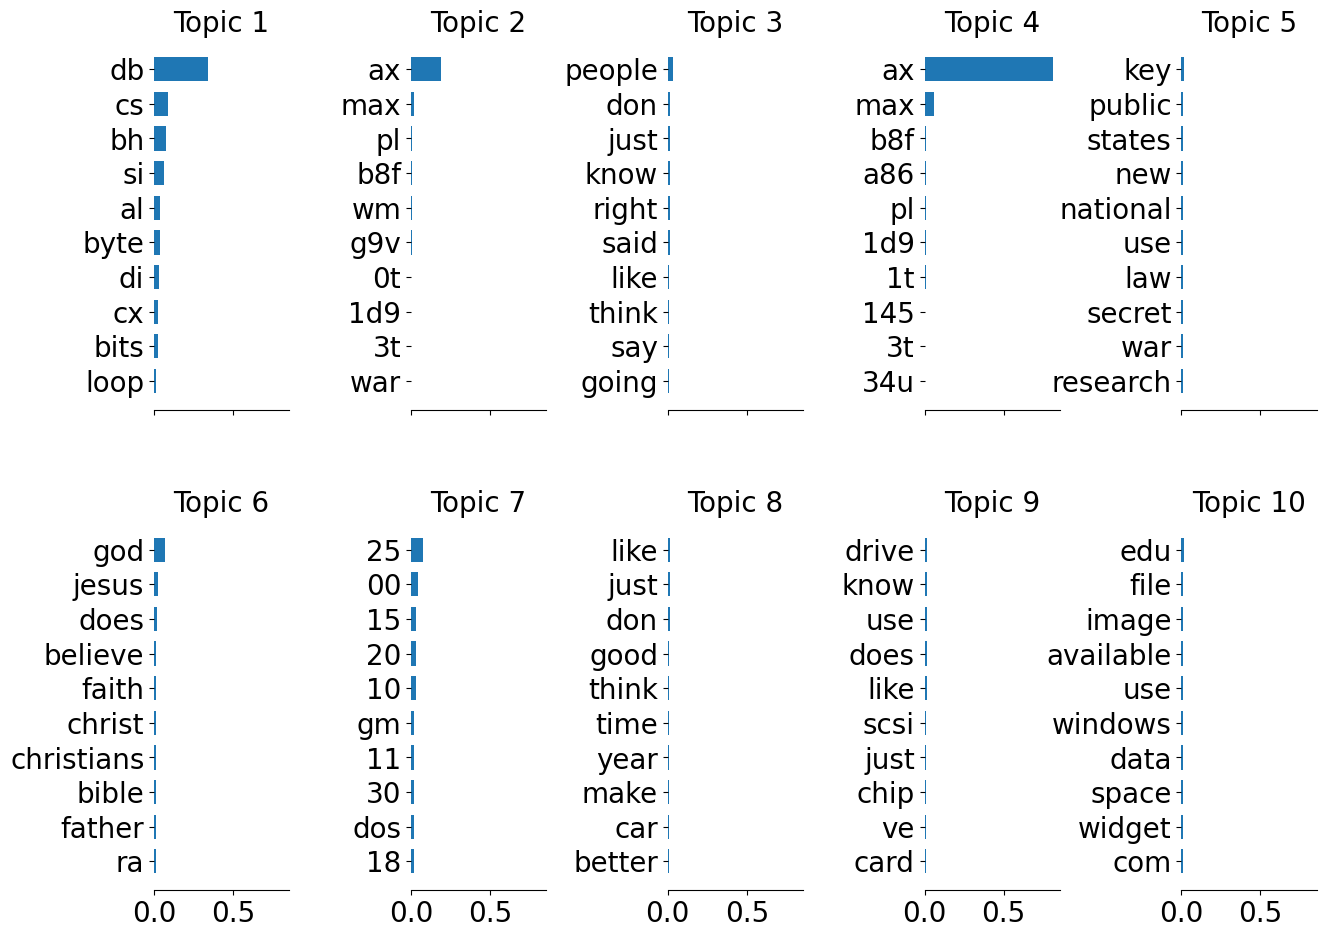

In [75]:
# This time, we're normalizing - what does this do?
fig, axes = plot_top_words(lda, tokens, normalize=True)
plt.show()

## Extra: Dimensionality Reduction [not covered]

In both NMF and LDA, we broke down the documents into topics. This was, in effect, a *change in representation*. We went from a DTM representation, to a representation of *topics*. 

Because there are fewer topics than there are tokens, we can think of this as a *dimensionality reduction*. This is desirable for several reasons, the main one being that it's easier to interpret, say, 10 dimensions than it is to interpret 1000.

This is computationally true, as well: once we get to higher dimensions, it's harder to compare different vectors with each other, because they generally end up all close to orthogonal. This is known as the *curse of dimensionality*.

Let's first transform the counts into the topic representation:

In [ ]:
topic_representation = lda.transform(counts)
topic_representation.shape

Let's use a familiar similarity measure to calculate the similarity between pairs of documents.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#similarily of the first few docs
#Notice something special about the diagonal? What does it mean?
cosine_similarity(topic_representation[:4])

### Try it yourself: Finding Similar Documents
Calculate the cosine similarity between all pairs of documents, and find the two documents whose cosine similarity is the highest. What are these documents? Do they seem similar?

In [ ]:
#Your code here